In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 5.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [ ]:
!pip install urllib3==1.25.4`

     |████████████████████████████████| 125 kB 8.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 4.5 MB/s 
     |████████████████████████████████| 90 kB 3.9 MB/s 
     |████████████████████████████████| 176 kB 7.1 MB/s 
     |████████████████████████████████| 131 kB 7.9 MB/s 
     |████████████████████████████████| 1.2 MB 6.5 MB/s 
     |████████████████████████████████| 883 kB 18.9 MB/s 
     |████████████████████████████████| 73 kB 1.2 MB/s 
     |████████████████████████████████| 7.3 MB 23.8 MB/s 
     |████████████████████████████████| 153 kB 51.3 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=92c5dddd3f6940a1703daf78018e8a160dfcb1907d17c1c51b5756195d29dc37
  Stored in directory: /root/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# BERT imports
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Final-project/data      #sem_7_project/data/version2

Bertprediction	      csv		  dict_embeddings1.pickle
cache_train_new_25gb  dev-v1.1.json	  dict_embeddings2.pickle
cache-train-store     dev-v2.0.json	  train-v1.1.json
cache_validation      dev-v2.0Short.json  train-v2.0.json


In [ ]:
%cd /content/drive/MyDrive/Final-project/data  

/content/drive/MyDrive/Final-project/data


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Final-project/data')

In [ ]:
""" Official evaluation script for SQuAD version 2.0.
    Modified by XLNet authors to update `find_best_threshold` scripts for SQuAD V2.0
In addition to basic functionality, we also compute additional statistics and
plot precision-recall curves if an additional na_prob.json file is provided.
This file is expected to map question ID's to the model's predicted probability
that a question is unanswerable.
"""
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys

class EVAL_OPTS():
  def __init__(self, data_file, pred_file, out_file="",
               na_prob_file="na_prob.json", na_prob_thresh=1.0,
               out_image_dir=None, verbose=False):
    self.data_file = data_file
    self.pred_file = pred_file
    self.out_file = out_file
    self.na_prob_file = na_prob_file
    self.na_prob_thresh = na_prob_thresh
    self.out_image_dir = out_image_dir
    self.verbose = verbose

OPTS = None

def parse_args():
  parser = argparse.ArgumentParser('Official evaluation script for SQuAD version 2.0.')
  parser.add_argument('data_file', metavar='data.json', help='Input data JSON file.')
  parser.add_argument('pred_file', metavar='pred.json', help='Model predictions.')
  parser.add_argument('--out-file', '-o', metavar='eval.json',
                      help='Write accuracy metrics to file (default is stdout).')
  parser.add_argument('--na-prob-file', '-n', metavar='na_prob.json',
                      help='Model estimates of probability of no answer.')
  parser.add_argument('--na-prob-thresh', '-t', type=float, default=1.0,
                      help='Predict "" if no-answer probability exceeds this (default = 1.0).')
  parser.add_argument('--out-image-dir', '-p', metavar='out_images', default=None,
                      help='Save precision-recall curves to directory.')
  parser.add_argument('--verbose', '-v', action='store_true')
  if len(sys.argv) == 1:
    parser.print_help()
    sys.exit(1)
  return parser.parse_args()

def make_qid_to_has_ans(dataset):
  qid_to_has_ans = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid_to_has_ans[qa['id']] = bool(qa['answers'])
  return qid_to_has_ans

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def get_raw_scores(dataset, preds):
  exact_scores = {}
  f1_scores = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid = qa['id']
        gold_answers = [a['text'] for a in qa['answers']
                        if normalize_answer(a['text'])]
        if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
          gold_answers = ['']
        if qid not in preds:
          print('Missing prediction for %s' % qid)
          continue
        a_pred = preds[qid]
        # Take max over all gold answers
        exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
        f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
  return exact_scores, f1_scores

def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans, na_prob_thresh):
  new_scores = {}
  for qid, s in scores.items():
    pred_na = na_probs[qid] > na_prob_thresh
    if pred_na:
      new_scores[qid] = float(not qid_to_has_ans[qid])
    else:
      new_scores[qid] = s
  return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
  if not qid_list:
    total = len(exact_scores)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores.values()) / total),
        ('f1', 100.0 * sum(f1_scores.values()) / total),
        ('total', total),
    ])
  else:
    total = len(qid_list)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores[k] for k in qid_list) / total),
        ('f1', 100.0 * sum(f1_scores[k] for k in qid_list) / total),
        ('total', total),
    ])

def merge_eval(main_eval, new_eval, prefix):
  for k in new_eval:
    main_eval['%s_%s' % (prefix, k)] = new_eval[k]

def plot_pr_curve(precisions, recalls, out_image, title):
  plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
  plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.title(title)
  plt.savefig(out_image)
  plt.clf()

def make_precision_recall_eval(scores, na_probs, num_true_pos, qid_to_has_ans,
                               out_image=None, title=None):
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  true_pos = 0.0
  cur_p = 1.0
  cur_r = 0.0
  precisions = [1.0]
  recalls = [0.0]
  avg_prec = 0.0
  for i, qid in enumerate(qid_list):
    if qid_to_has_ans[qid]:
      true_pos += scores[qid]
    cur_p = true_pos / float(i+1)
    cur_r = true_pos / float(num_true_pos)
    if i == len(qid_list) - 1 or na_probs[qid] != na_probs[qid_list[i+1]]:
      # i.e., if we can put a threshold after this point
      avg_prec += cur_p * (cur_r - recalls[-1])
      precisions.append(cur_p)
      recalls.append(cur_r)
  if out_image:
    plot_pr_curve(precisions, recalls, out_image, title)
  return {'ap': 100.0 * avg_prec}

def run_precision_recall_analysis(main_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, out_image_dir):
  if out_image_dir and not os.path.exists(out_image_dir):
    os.makedirs(out_image_dir)
  num_true_pos = sum(1 for v in qid_to_has_ans.values() if v)
  if num_true_pos == 0:
    return
  pr_exact = make_precision_recall_eval(
      exact_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_exact.png'),
      title='Precision-Recall curve for Exact Match score')
  pr_f1 = make_precision_recall_eval(
      f1_raw, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_f1.png'),
      title='Precision-Recall curve for F1 score')
  oracle_scores = {k: float(v) for k, v in qid_to_has_ans.items()}
  pr_oracle = make_precision_recall_eval(
      oracle_scores, na_probs, num_true_pos, qid_to_has_ans,
      out_image=os.path.join(out_image_dir, 'pr_oracle.png'),
      title='Oracle Precision-Recall curve (binary task of HasAns vs. NoAns)')
  merge_eval(main_eval, pr_exact, 'pr_exact')
  merge_eval(main_eval, pr_f1, 'pr_f1')
  merge_eval(main_eval, pr_oracle, 'pr_oracle')

def histogram_na_prob(na_probs, qid_list, image_dir, name):
  if not qid_list:
    return
  x = [na_probs[k] for k in qid_list]
  weights = np.ones_like(x) / float(len(x))
  plt.hist(x, weights=weights, bins=20, range=(0.0, 1.0))
  plt.xlabel('Model probability of no-answer')
  plt.ylabel('Proportion of dataset')
  plt.title('Histogram of no-answer probability: %s' % name)
  plt.savefig(os.path.join(image_dir, 'na_prob_hist_%s.png' % name))
  plt.clf()

def find_best_thresh(preds, scores, na_probs, qid_to_has_ans):
  num_no_ans = sum(1 for k in qid_to_has_ans if not qid_to_has_ans[k])
  cur_score = num_no_ans
  best_score = cur_score
  best_thresh = 0.0
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  for i, qid in enumerate(qid_list):
    if qid not in scores: continue
    if qid_to_has_ans[qid]:
      diff = scores[qid]
    else:
      if preds[qid]:
        diff = -1
      else:
        diff = 0
    cur_score += diff
    if cur_score > best_score:
      best_score = cur_score
      best_thresh = na_probs[qid]
  return 100.0 * best_score / len(scores), best_thresh

def find_best_thresh_v2(preds, scores, na_probs, qid_to_has_ans):
  num_no_ans = sum(1 for k in qid_to_has_ans if not qid_to_has_ans[k])
  cur_score = num_no_ans
  best_score = cur_score
  best_thresh = 0.0
  qid_list = sorted(na_probs, key=lambda k: na_probs[k])
  for i, qid in enumerate(qid_list):
    if qid not in scores: continue
    if qid_to_has_ans[qid]:
      diff = scores[qid]
    else:
      if preds[qid]:
        diff = -1
      else:
        diff = 0
    cur_score += diff
    if cur_score > best_score:
      best_score = cur_score
      best_thresh = na_probs[qid]

  has_ans_score, has_ans_cnt = 0, 0
  for qid in qid_list:
    if not qid_to_has_ans[qid]: continue
    has_ans_cnt += 1

    if qid not in scores: continue
    has_ans_score += scores[qid]

  return 100.0 * best_score / len(scores), best_thresh, 1.0 * has_ans_score / has_ans_cnt

def find_all_best_thresh(main_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans):
  best_exact, exact_thresh = find_best_thresh(preds, exact_raw, na_probs, qid_to_has_ans)
  best_f1, f1_thresh = find_best_thresh(preds, f1_raw, na_probs, qid_to_has_ans)
  main_eval['best_exact'] = best_exact
  main_eval['best_exact_thresh'] = exact_thresh
  main_eval['best_f1'] = best_f1
  main_eval['best_f1_thresh'] = f1_thresh

def find_all_best_thresh_v2(main_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans):
  best_exact, exact_thresh, has_ans_exact = find_best_thresh_v2(preds, exact_raw, na_probs, qid_to_has_ans)
  best_f1, f1_thresh, has_ans_f1 = find_best_thresh_v2(preds, f1_raw, na_probs, qid_to_has_ans)
  main_eval['best_exact'] = best_exact
  main_eval['best_exact_thresh'] = exact_thresh
  main_eval['best_f1'] = best_f1
  main_eval['best_f1_thresh'] = f1_thresh
  main_eval['has_ans_exact'] = has_ans_exact
  main_eval['has_ans_f1'] = has_ans_f1

def main(OPTS):
  with open(OPTS.data_file) as f:
    dataset_json = json.load(f)
    dataset = dataset_json['data']
  with open(OPTS.pred_file) as f:
    preds = json.load(f)
  if OPTS.na_prob_file:
    with open(OPTS.na_prob_file) as f:
      na_probs = json.load(f)
  else:
    na_probs = {k: 0.0 for k in preds}
  qid_to_has_ans = make_qid_to_has_ans(dataset)  # maps qid to True/False
  has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
  no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
  exact_raw, f1_raw = get_raw_scores(dataset, preds)
  exact_thresh = apply_no_ans_threshold(exact_raw, na_probs, qid_to_has_ans,
                                        OPTS.na_prob_thresh)
  f1_thresh = apply_no_ans_threshold(f1_raw, na_probs, qid_to_has_ans,
                                     OPTS.na_prob_thresh)
  out_eval = make_eval_dict(exact_thresh, f1_thresh)
  if has_ans_qids:
    has_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=has_ans_qids)
    merge_eval(out_eval, has_ans_eval, 'HasAns')
  if no_ans_qids:
    no_ans_eval = make_eval_dict(exact_thresh, f1_thresh, qid_list=no_ans_qids)
    merge_eval(out_eval, no_ans_eval, 'NoAns')
  if OPTS.na_prob_file:
    find_all_best_thresh(out_eval, preds, exact_raw, f1_raw, na_probs, qid_to_has_ans)
  if OPTS.na_prob_file and OPTS.out_image_dir:
    run_precision_recall_analysis(out_eval, exact_raw, f1_raw, na_probs, 
                                  qid_to_has_ans, OPTS.out_image_dir)
    histogram_na_prob(na_probs, has_ans_qids, OPTS.out_image_dir, 'hasAns')
    histogram_na_prob(na_probs, no_ans_qids, OPTS.out_image_dir, 'noAns')
  if OPTS.out_file:
    with open(OPTS.out_file, 'w') as f:
      json.dump(out_eval, f)
  else:
    print(json.dumps(out_eval, indent=2))
  return out_eval

# if __name__ == '__main__':
#   OPTS = parse_args()
#   if OPTS.out_image_dir:
#     import matplotlib
#     matplotlib.use('Agg')
#     import matplotlib.pyplot as plt 
#   main(OPTS)

In [ ]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Load SQuAD dataset. """

from __future__ import absolute_import, division, print_function

import json
import logging
import math
import collections
from io import open

from pytorch_transformers.tokenization_bert import BasicTokenizer, whitespace_tokenize

# Required by XLNet evaluation method to compute optimal threshold (see write_predictions_extended() method)
# from utils_squad_evaluate import find_all_best_thresh_v2, make_qid_to_has_ans, get_raw_scores

logger = logging.getLogger(__name__)


class SquadExample(object):
    """
    A single training/test example for the Squad dataset.
    For examples without an answer, the start and end position are -1.
    """

    def __init__(self,
                 qas_id,
                 question_text,
                 doc_tokens,
                 orig_answer_text=None,
                 start_position=None,
                 end_position=None,
                 is_impossible=None):
        self.qas_id = qas_id
        self.question_text = question_text
        self.doc_tokens = doc_tokens
        self.orig_answer_text = orig_answer_text
        self.start_position = start_position
        self.end_position = end_position
        self.is_impossible = is_impossible

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        s = ""
        s += "qas_id: %s" % (self.qas_id)
        s += ", question_text: %s" % (
            self.question_text)
        s += ", doc_tokens: [%s]" % (" ".join(self.doc_tokens))
        if self.start_position:
            s += ", start_position: %d" % (self.start_position)
        if self.end_position:
            s += ", end_position: %d" % (self.end_position)
        if self.is_impossible:
            s += ", is_impossible: %r" % (self.is_impossible)
        return s


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 unique_id,
                 example_index,
                 doc_span_index,
                 tokens,
                 token_to_orig_map,
                 token_is_max_context,
                 input_ids,
                 input_mask,
                 segment_ids,
                 cls_index,
                 p_mask,
                 paragraph_len,
                 start_position=None,
                 end_position=None,
                 is_impossible=None):
        self.unique_id = unique_id
        self.example_index = example_index
        self.doc_span_index = doc_span_index
        self.tokens = tokens
        self.token_to_orig_map = token_to_orig_map
        self.token_is_max_context = token_is_max_context
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.cls_index = cls_index
        self.p_mask = p_mask
        self.paragraph_len = paragraph_len
        self.start_position = start_position
        self.end_position = end_position
        self.is_impossible = is_impossible


def read_squad_examples(input_file, is_training, version_2_with_negative):
    """Read a SQuAD json file into a list of SquadExample."""
    with open(input_file, "r", encoding='utf-8') as reader:
        input_data = json.load(reader)["data"]

    def is_whitespace(c):
        if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
            return True
        return False

    examples = []
    for entry in input_data:
        for paragraph in entry["paragraphs"]:
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
            prev_is_whitespace = True
            for c in paragraph_text:
                if is_whitespace(c):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(c)
                    else:
                        doc_tokens[-1] += c
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)

            for qa in paragraph["qas"]:
                qas_id = qa["id"]
                question_text = qa["question"]
                start_position = None
                end_position = None
                orig_answer_text = None
                is_impossible = False
                if is_training:
                    if version_2_with_negative:
                        is_impossible = qa["is_impossible"]
                    if (len(qa["answers"]) != 1) and (not is_impossible):
                        raise ValueError(
                            "For training, each question should have exactly 1 answer.")
                    if not is_impossible:
                        answer = qa["answers"][0]
                        orig_answer_text = answer["text"]
                        answer_offset = answer["answer_start"]
                        answer_length = len(orig_answer_text)
                        start_position = char_to_word_offset[answer_offset]
                        end_position = char_to_word_offset[answer_offset + answer_length - 1]
                        # Only add answers where the text can be exactly recovered from the
                        # document. If this CAN'T happen it's likely due to weird Unicode
                        # stuff so we will just skip the example.
                        #
                        # Note that this means for training mode, every example is NOT
                        # guaranteed to be preserved.
                        actual_text = " ".join(doc_tokens[start_position:(end_position + 1)])
                        cleaned_answer_text = " ".join(
                            whitespace_tokenize(orig_answer_text))
                        if actual_text.find(cleaned_answer_text) == -1:
                            logger.warning("Could not find answer: '%s' vs. '%s'",
                                           actual_text, cleaned_answer_text)
                            continue
                    else:
                        start_position = -1
                        end_position = -1
                        orig_answer_text = ""

                example = SquadExample(
                    qas_id=qas_id,
                    question_text=question_text,
                    doc_tokens=doc_tokens,
                    orig_answer_text=orig_answer_text,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=is_impossible)
                examples.append(example)
    return examples


def convert_examples_to_features(examples, tokenizer, max_seq_length,
                                 doc_stride, max_query_length, is_training,
                                 cls_token_at_end=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=0, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """Loads a data file into a list of `InputBatch`s."""

    unique_id = 1000000000
    # cnt_pos, cnt_neg = 0, 0
    # max_N, max_M = 1024, 1024
    # f = np.zeros((max_N, max_M), dtype=np.float32)

    features = []
    for (example_index, example) in enumerate(examples):

        # if example_index % 100 == 0:
        #     logger.info('Converting %s/%s pos %s neg %s', example_index, len(examples), cnt_pos, cnt_neg)

        query_tokens = tokenizer.tokenize(example.question_text)

        if len(query_tokens) > max_query_length:
            query_tokens = query_tokens[0:max_query_length]

        tok_to_orig_index = []
        orig_to_tok_index = []
        all_doc_tokens = []
        for (i, token) in enumerate(example.doc_tokens):
            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tokenizer.tokenize(token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)

        tok_start_position = None
        tok_end_position = None
        if is_training and example.is_impossible:
            tok_start_position = -1
            tok_end_position = -1
        if is_training and not example.is_impossible:
            tok_start_position = orig_to_tok_index[example.start_position]
            if example.end_position < len(example.doc_tokens) - 1:
                tok_end_position = orig_to_tok_index[example.end_position + 1] - 1
            else:
                tok_end_position = len(all_doc_tokens) - 1
            (tok_start_position, tok_end_position) = _improve_answer_span(
                all_doc_tokens, tok_start_position, tok_end_position, tokenizer,
                example.orig_answer_text)

        # The -3 accounts for [CLS], [SEP] and [SEP]
        max_tokens_for_doc = max_seq_length - len(query_tokens) - 3

        # We can have documents that are longer than the maximum sequence length.
        # To deal with this we do a sliding window approach, where we take chunks
        # of the up to our max length with a stride of `doc_stride`.
        _DocSpan = collections.namedtuple(  # pylint: disable=invalid-name
            "DocSpan", ["start", "length"])
        doc_spans = []
        start_offset = 0
        while start_offset < len(all_doc_tokens):
            length = len(all_doc_tokens) - start_offset
            if length > max_tokens_for_doc:
                length = max_tokens_for_doc
            doc_spans.append(_DocSpan(start=start_offset, length=length))
            if start_offset + length == len(all_doc_tokens):
                break
            start_offset += min(length, doc_stride)

        for (doc_span_index, doc_span) in enumerate(doc_spans):
            tokens = []
            token_to_orig_map = {}
            token_is_max_context = {}
            segment_ids = []

            # p_mask: mask with 1 for token than cannot be in the answer (0 for token which can be in an answer)
            # Original TF implem also keep the classification token (set to 0) (not sure why...)
            p_mask = []

            # CLS token at the beginning
            if not cls_token_at_end:
                tokens.append(cls_token)
                segment_ids.append(cls_token_segment_id)
                p_mask.append(0)
                cls_index = 0

            # Query
            for token in query_tokens:
                tokens.append(token)
                segment_ids.append(sequence_a_segment_id)
                p_mask.append(1)

            # SEP token
            tokens.append(sep_token)
            segment_ids.append(sequence_a_segment_id)
            p_mask.append(1)

            # Paragraph
            for i in range(doc_span.length):
                split_token_index = doc_span.start + i
                token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]

                is_max_context = _check_is_max_context(doc_spans, doc_span_index,
                                                       split_token_index)
                token_is_max_context[len(tokens)] = is_max_context
                tokens.append(all_doc_tokens[split_token_index])
                segment_ids.append(sequence_b_segment_id)
                p_mask.append(0)
            paragraph_len = doc_span.length

            # SEP token
            tokens.append(sep_token)
            segment_ids.append(sequence_b_segment_id)
            p_mask.append(1)

            # CLS token at the end
            if cls_token_at_end:
                tokens.append(cls_token)
                segment_ids.append(cls_token_segment_id)
                p_mask.append(0)
                cls_index = len(tokens) - 1  # Index of classification token

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

            # Zero-pad up to the sequence length.
            while len(input_ids) < max_seq_length:
                input_ids.append(pad_token)
                input_mask.append(0 if mask_padding_with_zero else 1)
                segment_ids.append(pad_token_segment_id)
                p_mask.append(1)

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            span_is_impossible = example.is_impossible
            start_position = None
            end_position = None
            if is_training and not span_is_impossible:
                # For training, if our document chunk does not contain an annotation
                # we throw it out, since there is nothing to predict.
                doc_start = doc_span.start
                doc_end = doc_span.start + doc_span.length - 1
                out_of_span = False
                if not (tok_start_position >= doc_start and
                        tok_end_position <= doc_end):
                    out_of_span = True
                if out_of_span:
                    start_position = 0
                    end_position = 0
                    span_is_impossible = True
                else:
                    doc_offset = len(query_tokens) + 2
                    start_position = tok_start_position - doc_start + doc_offset
                    end_position = tok_end_position - doc_start + doc_offset

            if is_training and span_is_impossible:
                start_position = cls_index
                end_position = cls_index

            if example_index < 20:
                logger.info("*** Example ***")
                logger.info("unique_id: %s" % (unique_id))
                logger.info("example_index: %s" % (example_index))
                logger.info("doc_span_index: %s" % (doc_span_index))
                logger.info("tokens: %s" % " ".join(tokens))
                logger.info("token_to_orig_map: %s" % " ".join([
                    "%d:%d" % (x, y) for (x, y) in token_to_orig_map.items()]))
                logger.info("token_is_max_context: %s" % " ".join([
                    "%d:%s" % (x, y) for (x, y) in token_is_max_context.items()
                ]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info(
                    "input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
                if is_training and span_is_impossible:
                    logger.info("impossible example")
                if is_training and not span_is_impossible:
                    answer_text = " ".join(tokens[start_position:(end_position + 1)])
                    logger.info("start_position: %d" % (start_position))
                    logger.info("end_position: %d" % (end_position))
                    logger.info(
                        "answer: %s" % (answer_text))

            features.append(
                InputFeatures(
                    unique_id=unique_id,
                    example_index=example_index,
                    doc_span_index=doc_span_index,
                    tokens=tokens,
                    token_to_orig_map=token_to_orig_map,
                    token_is_max_context=token_is_max_context,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    cls_index=cls_index,
                    p_mask=p_mask,
                    paragraph_len=paragraph_len,
                    start_position=start_position,
                    end_position=end_position,
                    is_impossible=span_is_impossible))
            unique_id += 1

    return features


def _improve_answer_span(doc_tokens, input_start, input_end, tokenizer,
                         orig_answer_text):
    """Returns tokenized answer spans that better match the annotated answer."""

    # The SQuAD annotations are character based. We first project them to
    # whitespace-tokenized words. But then after WordPiece tokenization, we can
    # often find a "better match". For example:
    #
    #   Question: What year was John Smith born?
    #   Context: The leader was John Smith (1895-1943).
    #   Answer: 1895
    #
    # The original whitespace-tokenized answer will be "(1895-1943).". However
    # after tokenization, our tokens will be "( 1895 - 1943 ) .". So we can match
    # the exact answer, 1895.
    #
    # However, this is not always possible. Consider the following:
    #
    #   Question: What country is the top exporter of electornics?
    #   Context: The Japanese electronics industry is the lagest in the world.
    #   Answer: Japan
    #
    # In this case, the annotator chose "Japan" as a character sub-span of
    # the word "Japanese". Since our WordPiece tokenizer does not split
    # "Japanese", we just use "Japanese" as the annotation. This is fairly rare
    # in SQuAD, but does happen.
    tok_answer_text = " ".join(tokenizer.tokenize(orig_answer_text))

    for new_start in range(input_start, input_end + 1):
        for new_end in range(input_end, new_start - 1, -1):
            text_span = " ".join(doc_tokens[new_start:(new_end + 1)])
            if text_span == tok_answer_text:
                return (new_start, new_end)

    return (input_start, input_end)


def _check_is_max_context(doc_spans, cur_span_index, position):
    """Check if this is the 'max context' doc span for the token."""

    # Because of the sliding window approach taken to scoring documents, a single
    # token can appear in multiple documents. E.g.
    #  Doc: the man went to the store and bought a gallon of milk
    #  Span A: the man went to the
    #  Span B: to the store and bought
    #  Span C: and bought a gallon of
    #  ...
    #
    # Now the word 'bought' will have two scores from spans B and C. We only
    # want to consider the score with "maximum context", which we define as
    # the *minimum* of its left and right context (the *sum* of left and
    # right context will always be the same, of course).
    #
    # In the example the maximum context for 'bought' would be span C since
    # it has 1 left context and 3 right context, while span B has 4 left context
    # and 0 right context.
    best_score = None
    best_span_index = None
    for (span_index, doc_span) in enumerate(doc_spans):
        end = doc_span.start + doc_span.length - 1
        if position < doc_span.start:
            continue
        if position > end:
            continue
        num_left_context = position - doc_span.start
        num_right_context = end - position
        score = min(num_left_context, num_right_context) + 0.01 * doc_span.length
        if best_score is None or score > best_score:
            best_score = score
            best_span_index = span_index

    return cur_span_index == best_span_index


RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits"])

def write_predictions(all_examples, all_features, all_results, n_best_size,
                      max_answer_length, do_lower_case, output_prediction_file,
                      output_nbest_file, output_null_log_odds_file, verbose_logging,
                      version_2_with_negative, null_score_diff_threshold):
    """Write final predictions to the json file and log-odds of null if needed."""
    logger.info("Writing predictions to: %s" % (output_prediction_file))
    logger.info("Writing nbest to: %s" % (output_nbest_file))

    example_index_to_features = collections.defaultdict(list)
    for feature in all_features:
        example_index_to_features[feature.example_index].append(feature)

    unique_id_to_result = {}
    for result in all_results:
        unique_id_to_result[result.unique_id] = result

    _PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "PrelimPrediction",
        ["feature_index", "start_index", "end_index", "start_logit", "end_logit"])

    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    scores_diff_json = collections.OrderedDict()

    for (example_index, example) in enumerate(all_examples):
        features = example_index_to_features[example_index]

        prelim_predictions = []
        # keep track of the minimum score of null start+end of position 0
        score_null = 1000000  # large and positive
        min_null_feature_index = 0  # the paragraph slice with min null score
        null_start_logit = 0  # the start logit at the slice with min null score
        null_end_logit = 0  # the end logit at the slice with min null score
        for (feature_index, feature) in enumerate(features):
            result = unique_id_to_result[feature.unique_id]
            start_indexes = _get_best_indexes(result.start_logits, n_best_size)
            end_indexes = _get_best_indexes(result.end_logits, n_best_size)
            # if we could have irrelevant answers, get the min score of irrelevant
            if version_2_with_negative:
                feature_null_score = result.start_logits[0] + result.end_logits[0]
                if feature_null_score < score_null:
                    score_null = feature_null_score
                    min_null_feature_index = feature_index
                    null_start_logit = result.start_logits[0]
                    null_end_logit = result.end_logits[0]
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # We could hypothetically create invalid predictions, e.g., predict
                    # that the start of the span is in the question. We throw out all
                    # invalid predictions.
                    if start_index >= len(feature.tokens):
                        continue
                    if end_index >= len(feature.tokens):
                        continue
                    if start_index not in feature.token_to_orig_map:
                        continue
                    if end_index not in feature.token_to_orig_map:
                        continue
                    if not feature.token_is_max_context.get(start_index, False):
                        continue
                    if end_index < start_index:
                        continue
                    length = end_index - start_index + 1
                    if length > max_answer_length:
                        continue
                    prelim_predictions.append(
                        _PrelimPrediction(
                            feature_index=feature_index,
                            start_index=start_index,
                            end_index=end_index,
                            start_logit=result.start_logits[start_index],
                            end_logit=result.end_logits[end_index]))
        if version_2_with_negative:
            prelim_predictions.append(
                _PrelimPrediction(
                    feature_index=min_null_feature_index,
                    start_index=0,
                    end_index=0,
                    start_logit=null_start_logit,
                    end_logit=null_end_logit))
        prelim_predictions = sorted(
            prelim_predictions,
            key=lambda x: (x.start_logit + x.end_logit),
            reverse=True)

        _NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "NbestPrediction", ["text", "start_logit", "end_logit"])

        seen_predictions = {}
        nbest = []
        for pred in prelim_predictions:
            if len(nbest) >= n_best_size:
                break
            feature = features[pred.feature_index]
            if pred.start_index > 0:  # this is a non-null prediction
                tok_tokens = feature.tokens[pred.start_index:(pred.end_index + 1)]
                orig_doc_start = feature.token_to_orig_map[pred.start_index]
                orig_doc_end = feature.token_to_orig_map[pred.end_index]
                orig_tokens = example.doc_tokens[orig_doc_start:(orig_doc_end + 1)]
                tok_text = " ".join(tok_tokens)

                # De-tokenize WordPieces that have been split off.
                tok_text = tok_text.replace(" ##", "")
                tok_text = tok_text.replace("##", "")

                # Clean whitespace
                tok_text = tok_text.strip()
                tok_text = " ".join(tok_text.split())
                orig_text = " ".join(orig_tokens)

                final_text = get_final_text(tok_text, orig_text, do_lower_case, verbose_logging)
                if final_text in seen_predictions:
                    continue

                seen_predictions[final_text] = True
            else:
                final_text = ""
                seen_predictions[final_text] = True

            nbest.append(
                _NbestPrediction(
                    text=final_text,
                    start_logit=pred.start_logit,
                    end_logit=pred.end_logit))
        # if we didn't include the empty option in the n-best, include it
        if version_2_with_negative:
            if "" not in seen_predictions:
                nbest.append(
                    _NbestPrediction(
                        text="",
                        start_logit=null_start_logit,
                        end_logit=null_end_logit))
                
            # In very rare edge cases we could only have single null prediction.
            # So we just create a nonce prediction in this case to avoid failure.
            if len(nbest)==1:
                nbest.insert(0,
                    _NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0))

        # In very rare edge cases we could have no valid predictions. So we
        # just create a nonce prediction in this case to avoid failure.
        if not nbest:
            nbest.append(
                _NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0))

        assert len(nbest) >= 1

        total_scores = []
        best_non_null_entry = None
        for entry in nbest:
            total_scores.append(entry.start_logit + entry.end_logit)
            if not best_non_null_entry:
                if entry.text:
                    best_non_null_entry = entry

        probs = _compute_softmax(total_scores)

        nbest_json = []
        for (i, entry) in enumerate(nbest):
            output = collections.OrderedDict()
            output["text"] = entry.text
            output["probability"] = probs[i]
            output["start_logit"] = entry.start_logit
            output["end_logit"] = entry.end_logit
            nbest_json.append(output)

        assert len(nbest_json) >= 1

        if not version_2_with_negative:
            all_predictions[example.qas_id] = nbest_json[0]["text"]
        else:
            # predict "" iff the null score - the score of best non-null > threshold
            score_diff = score_null - best_non_null_entry.start_logit - (
                best_non_null_entry.end_logit)
            scores_diff_json[example.qas_id] = score_diff
            if score_diff > null_score_diff_threshold:
                all_predictions[example.qas_id] = ""
            else:
                all_predictions[example.qas_id] = best_non_null_entry.text
        all_nbest_json[example.qas_id] = nbest_json

    with open(output_prediction_file, "w") as writer:
        writer.write(json.dumps(all_predictions, indent=4) + "\n")

    with open(output_nbest_file, "w") as writer:
        writer.write(json.dumps(all_nbest_json, indent=4) + "\n")

    if version_2_with_negative:
        with open(output_null_log_odds_file, "w") as writer:
            writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

    return all_predictions


# For XLNet (and XLM which uses the same head)
RawResultExtended = collections.namedtuple("RawResultExtended",
    ["unique_id", "start_top_log_probs", "start_top_index",
     "end_top_log_probs", "end_top_index", "cls_logits"])


def write_predictions_extended(all_examples, all_features, all_results, n_best_size,
                                max_answer_length, output_prediction_file,
                                output_nbest_file,
                                output_null_log_odds_file, orig_data_file,
                                start_n_top, end_n_top, version_2_with_negative,
                                tokenizer, verbose_logging):
    """ XLNet write prediction logic (more complex than Bert's).
        Write final predictions to the json file and log-odds of null if needed.
        Requires utils_squad_evaluate.py
    """
    _PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "PrelimPrediction",
        ["feature_index", "start_index", "end_index",
        "start_log_prob", "end_log_prob"])

    _NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "NbestPrediction", ["text", "start_log_prob", "end_log_prob"])

    logger.info("Writing predictions to: %s", output_prediction_file)
    # logger.info("Writing nbest to: %s" % (output_nbest_file))

    example_index_to_features = collections.defaultdict(list)
    for feature in all_features:
        example_index_to_features[feature.example_index].append(feature)

    unique_id_to_result = {}
    for result in all_results:
        unique_id_to_result[result.unique_id] = result

    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    scores_diff_json = collections.OrderedDict()

    for (example_index, example) in enumerate(all_examples):
        features = example_index_to_features[example_index]

        prelim_predictions = []
        # keep track of the minimum score of null start+end of position 0
        score_null = 1000000  # large and positive

        for (feature_index, feature) in enumerate(features):
            result = unique_id_to_result[feature.unique_id]

            cur_null_score = result.cls_logits

            # if we could have irrelevant answers, get the min score of irrelevant
            score_null = min(score_null, cur_null_score)

            for i in range(start_n_top):
                for j in range(end_n_top):
                    start_log_prob = result.start_top_log_probs[i]
                    start_index = result.start_top_index[i]

                    j_index = i * end_n_top + j

                    end_log_prob = result.end_top_log_probs[j_index]
                    end_index = result.end_top_index[j_index]

                    # We could hypothetically create invalid predictions, e.g., predict
                    # that the start of the span is in the question. We throw out all
                    # invalid predictions.
                    if start_index >= feature.paragraph_len - 1:
                        continue
                    if end_index >= feature.paragraph_len - 1:
                        continue

                    if not feature.token_is_max_context.get(start_index, False):
                        continue
                    if end_index < start_index:
                        continue
                    length = end_index - start_index + 1
                    if length > max_answer_length:
                        continue

                    prelim_predictions.append(
                        _PrelimPrediction(
                            feature_index=feature_index,
                            start_index=start_index,
                            end_index=end_index,
                            start_log_prob=start_log_prob,
                            end_log_prob=end_log_prob))

        prelim_predictions = sorted(
            prelim_predictions,
            key=lambda x: (x.start_log_prob + x.end_log_prob),
            reverse=True)

        seen_predictions = {}
        nbest = []
        for pred in prelim_predictions:
            if len(nbest) >= n_best_size:
                break
            feature = features[pred.feature_index]

            # XLNet un-tokenizer
            # Let's keep it simple for now and see if we need all this later.
            # 
            # tok_start_to_orig_index = feature.tok_start_to_orig_index
            # tok_end_to_orig_index = feature.tok_end_to_orig_index
            # start_orig_pos = tok_start_to_orig_index[pred.start_index]
            # end_orig_pos = tok_end_to_orig_index[pred.end_index]
            # paragraph_text = example.paragraph_text
            # final_text = paragraph_text[start_orig_pos: end_orig_pos + 1].strip()

            # Previously used Bert untokenizer
            tok_tokens = feature.tokens[pred.start_index:(pred.end_index + 1)]
            orig_doc_start = feature.token_to_orig_map[pred.start_index]
            orig_doc_end = feature.token_to_orig_map[pred.end_index]
            orig_tokens = example.doc_tokens[orig_doc_start:(orig_doc_end + 1)]
            tok_text = tokenizer.convert_tokens_to_string(tok_tokens)

            # Clean whitespace
            tok_text = tok_text.strip()
            tok_text = " ".join(tok_text.split())
            orig_text = " ".join(orig_tokens)

            final_text = get_final_text(tok_text, orig_text, tokenizer.do_lower_case,
                                        verbose_logging)

            if final_text in seen_predictions:
                continue

            seen_predictions[final_text] = True

            nbest.append(
                _NbestPrediction(
                    text=final_text,
                    start_log_prob=pred.start_log_prob,
                    end_log_prob=pred.end_log_prob))

        # In very rare edge cases we could have no valid predictions. So we
        # just create a nonce prediction in this case to avoid failure.
        if not nbest:
            nbest.append(
                _NbestPrediction(text="", start_log_prob=-1e6,
                end_log_prob=-1e6))

        total_scores = []
        best_non_null_entry = None
        for entry in nbest:
            total_scores.append(entry.start_log_prob + entry.end_log_prob)
            if not best_non_null_entry:
                best_non_null_entry = entry

        probs = _compute_softmax(total_scores)

        nbest_json = []
        for (i, entry) in enumerate(nbest):
            output = collections.OrderedDict()
            output["text"] = entry.text
            output["probability"] = probs[i]
            output["start_log_prob"] = entry.start_log_prob
            output["end_log_prob"] = entry.end_log_prob
            nbest_json.append(output)

        assert len(nbest_json) >= 1
        assert best_non_null_entry is not None

        score_diff = score_null
        scores_diff_json[example.qas_id] = score_diff
        # note(zhiliny): always predict best_non_null_entry
        # and the evaluation script will search for the best threshold
        all_predictions[example.qas_id] = best_non_null_entry.text

        all_nbest_json[example.qas_id] = nbest_json

    with open(output_prediction_file, "w") as writer:
        writer.write(json.dumps(all_predictions, indent=4) + "\n")

    with open(output_nbest_file, "w") as writer:
        writer.write(json.dumps(all_nbest_json, indent=4) + "\n")

    if version_2_with_negative:
        with open(output_null_log_odds_file, "w") as writer:
            writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

    with open(orig_data_file, "r", encoding='utf-8') as reader:
        orig_data = json.load(reader)["data"]

    qid_to_has_ans = make_qid_to_has_ans(orig_data)
    has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
    no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
    exact_raw, f1_raw = get_raw_scores(orig_data, all_predictions)
    out_eval = {}

    find_all_best_thresh_v2(out_eval, all_predictions, exact_raw, f1_raw, scores_diff_json, qid_to_has_ans)

    return out_eval


def get_final_text(pred_text, orig_text, do_lower_case, verbose_logging=False):
    """Project the tokenized prediction back to the original text."""

    # When we created the data, we kept track of the alignment between original
    # (whitespace tokenized) tokens and our WordPiece tokenized tokens. So
    # now `orig_text` contains the span of our original text corresponding to the
    # span that we predicted.
    #
    # However, `orig_text` may contain extra characters that we don't want in
    # our prediction.
    #
    # For example, let's say:
    #   pred_text = steve smith
    #   orig_text = Steve Smith's
    #
    # We don't want to return `orig_text` because it contains the extra "'s".
    #
    # We don't want to return `pred_text` because it's already been normalized
    # (the SQuAD eval script also does punctuation stripping/lower casing but
    # our tokenizer does additional normalization like stripping accent
    # characters).
    #
    # What we really want to return is "Steve Smith".
    #
    # Therefore, we have to apply a semi-complicated alignment heuristic between
    # `pred_text` and `orig_text` to get a character-to-character alignment. This
    # can fail in certain cases in which case we just return `orig_text`.

    def _strip_spaces(text):
        ns_chars = []
        ns_to_s_map = collections.OrderedDict()
        for (i, c) in enumerate(text):
            if c == " ":
                continue
            ns_to_s_map[len(ns_chars)] = i
            ns_chars.append(c)
        ns_text = "".join(ns_chars)
        return (ns_text, ns_to_s_map)

    # We first tokenize `orig_text`, strip whitespace from the result
    # and `pred_text`, and check if they are the same length. If they are
    # NOT the same length, the heuristic has failed. If they are the same
    # length, we assume the characters are one-to-one aligned.
    tokenizer = BasicTokenizer(do_lower_case=do_lower_case)

    tok_text = " ".join(tokenizer.tokenize(orig_text))

    start_position = tok_text.find(pred_text)
    if start_position == -1:
        if verbose_logging:
            logger.info(
                "Unable to find text: '%s' in '%s'" % (pred_text, orig_text))
        return orig_text
    end_position = start_position + len(pred_text) - 1

    (orig_ns_text, orig_ns_to_s_map) = _strip_spaces(orig_text)
    (tok_ns_text, tok_ns_to_s_map) = _strip_spaces(tok_text)

    if len(orig_ns_text) != len(tok_ns_text):
        if verbose_logging:
            logger.info("Length not equal after stripping spaces: '%s' vs '%s'",
                        orig_ns_text, tok_ns_text)
        return orig_text

    # We then project the characters in `pred_text` back to `orig_text` using
    # the character-to-character alignment.
    tok_s_to_ns_map = {}
    for (i, tok_index) in tok_ns_to_s_map.items():
        tok_s_to_ns_map[tok_index] = i

    orig_start_position = None
    if start_position in tok_s_to_ns_map:
        ns_start_position = tok_s_to_ns_map[start_position]
        if ns_start_position in orig_ns_to_s_map:
            orig_start_position = orig_ns_to_s_map[ns_start_position]

    if orig_start_position is None:
        if verbose_logging:
            logger.info("Couldn't map start position")
        return orig_text

    orig_end_position = None
    if end_position in tok_s_to_ns_map:
        ns_end_position = tok_s_to_ns_map[end_position]
        if ns_end_position in orig_ns_to_s_map:
            orig_end_position = orig_ns_to_s_map[ns_end_position]

    if orig_end_position is None:
        if verbose_logging:
            logger.info("Couldn't map end position")
        return orig_text

    output_text = orig_text[orig_start_position:(orig_end_position + 1)]
    return output_text


def _get_best_indexes(logits, n_best_size):
    """Get the n-best logits from a list."""
    index_and_score = sorted(enumerate(logits), key=lambda x: x[1], reverse=True)

    best_indexes = []
    for i in range(len(index_and_score)):
        if i >= n_best_size:
            break
        best_indexes.append(index_and_score[i][0])
    return best_indexes


def _compute_softmax(scores):
    """Compute softmax probability over raw logits."""
    if not scores:
        return []

    max_score = None
    for score in scores:
        if max_score is None or score > max_score:
            max_score = score

    exp_scores = []
    total_sum = 0.0
    for score in scores:
        x = math.exp(score - max_score)
        exp_scores.append(x)
        total_sum += x

    probs = []
    for score in exp_scores:
        probs.append(score / total_sum)
    return probs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_file = '/content/drive/MyDrive/Final-project/data/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                               version_2_with_negative=True)

In [ ]:
examples[:6]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
32935,57098dc3ed30961900e842fc,When can the roots of orthodox judaism be trac...,"[The, roots, of, Orthodox, Judaism, can, be, t...",19th century,14,15,False
32936,57098dc3ed30961900e842fd,When did the German Jewry seek to reform Jewis...,"[The, roots, of, Orthodox, Judaism, can, be, t...",early 19th century,30,32,False
32937,57098dc3ed30961900e842fe,what did orthodox jews seek to modernize?,"[The, roots, of, Orthodox, Judaism, can, be, t...",education,48,48,False
32938,57098dc3ed30961900e842ff,what did the German Jewry reject about the Torah?,"[The, roots, of, Orthodox, Judaism, can, be, t...",absolute divine authorship,59,61,False
32939,5a578ab5770dc0001aeefc76,Which century can the roots of Orthodox Judais...,"[The, roots, of, Orthodox, Judaism, can, be, t...",,-1,-1,True
32940,5a578ab5770dc0001aeefc77,When did the Roman Jewry attempt to reform Jew...,"[The, roots, of, Orthodox, Judaism, can, be, t...",,-1,-1,True
32941,5a578ab5770dc0001aeefc78,What did the German Jewry attempt in response ...,"[The, roots, of, Orthodox, Judaism, can, be, t...",,-1,-1,True
32942,5a578ab5770dc0001aeefc79,Who made the claim that the Torah had divine a...,"[The, roots, of, Orthodox, Judaism, can, be, t...",,-1,-1,True
32943,5a578ab5770dc0001aeefc7a,What part of the Torah was considered non-bind...,"[The, roots, of, Orthodox, Judaism, can, be, t...",,-1,-1,True


In [ ]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No answer found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
Between 1949 and the 1980s, telephone communications in Greece were a state monopoly by
the Hellenic Telecommunications Organization, better known by its acronym, OTE. Despite the liberalization of
telephone communications in the country in the 1980s, OTE still dominates the Greek market
in its field and has emerged as one of the largest telecommunications companies in
Southeast Europe. Since 2011, the company's major shareholder is Deutsche Telekom with a 40%
stake, while the Greek state continues to own 10% of the company's shares. OTE
owns several subsidiaries across the Balkans, including Cosmote, Greece's top mobile telecommunications provider, Cosmote
Romania and Albanian Mobile Communications.
QUESTION:                                                                                            ANSWER:
Who ran the phones in Greece between 1949 and the 1980s?                                             state
What was the Hellenic Telecommunications Organization better kno

In [ ]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
16983,56e132ebcd28a01900c67699,When Catalan reach Sardinia?,"[During, the, 11th, and, 12th, centuries, the,...",14th century,45,46,False,59,28
47976,571ab9fd4faf5e1900b8ac23,What information is collected by Centers for M...,"[In, the, US,, starting, in, 2013,, under, the...",financial relationships with physicians and ho...,42,47,False,75,74
43896,570f887880d9841400ab35a3,How is Victoria related to Elizabeth?,"[Elizabeth's, many, historic, visits, and, mee...",great-great-grandmother,77,77,False,96,37
93998,5a3ea0cb5a76c5001a3a83d7,What happened to Palermo's population in the 1...,"[Sicily, fell, under, the, control, of, the, H...",,-1,-1,True,106,58
85183,572812962ca10214002d9d42,What aircraft did Steve Fossett use for his fl...,"[St., John's, was, the, starting, point, for, ...",replica Vickers Vimy,59,61,False,81,64


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 4658285.39B/s]


In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = '/content/drive/MyDrive/Final-project/data/cache_train_new_25gb'

In [ ]:
!ls /content/drive/MyDrive/Final-project/data/cache_train_new_25gb

/content/drive/MyDrive/Final-project/data/cache_train_new_25gb


In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/Final-project/temp/checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  print(global_step)
  ckpt_name = '/content/drive/MyDrive/Final-project/temp/checkpoint-{}'.format(global_step)
  # ckpt_name = '/content/drive/MyDrive/Final-project/temp/checkpoint-1500'

  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

9000
Loading model from checkpoint /content/drive/MyDrive/Final-project/temp/checkpoint-9000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0214,  0.0395, -0.0219,  ...,  0.0084, -0.0170,  0.0265],
        [ 0.0304,  0.0170, -0.0386,  ...,  0.0256,  0.0006,  0.0142]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0176, 0.0178], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
num_train_epochs = 10

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step = int(global_step)
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/Final-project/temp/checkpoint-{}'.format(global_step)
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)





Epoch:   0%|          | 0/10 [00:00<?, ?it/s]




Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]




Iteration:   3%|▎         | 232/9016 [00:00<00:03, 2315.07it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 10
  Batch size = 16
  Total optimization steps = 901







Iteration:   5%|▍         | 436/9016 [00:00<00:03, 2224.22it/s]




Iteration:   7%|▋         | 631/9016 [00:00<00:03, 2131.26it/s]




Iteration:  10%|▉         | 877/9016 [00:00<00:03, 2218.26it/s]




Iteration:  12%|█▏        | 1110/9016 [00:00<00:03, 2249.83it/s]




Iteration:  15%|█▌        | 1355/9016 [00:00<00:03, 2305.11it/s]




Iteration:  18%|█▊        | 1605/9016 [00:00<00:03, 2359.17it/s]




Iteration:  20%|██        | 1848/9016 [00:00<00:03, 2379.81it/s]




Iteration:  23%|██▎       | 2097/9016 [00:00<00:02, 2409.21it/s]




Iteration:  26%|██▌       | 2334/9016 [00:01<00:02, 2396.61it/s]




Iteration:  29%|██▊       | 2577/9016 [00:01<00:02, 2403.73it/s]




Iteration:  31%|███       | 2814/9016 [00:01<00:02, 2221.36it/s]




Iteration:  34%|███▎      | 3036/9016 [00:01<00:02, 2193.85it/s]




Iteration:  36%|███▋      | 3290/9016 [00:01<00:02, 2287.34it/s]




Iteration:  39%|███▉      | 3539/9016 [00:01<00:02, 2342.63it/s]




Iteration:  42%|████▏     | 3775

In [ ]:
output_dir = '/drive/My Drive/Final-project/temp/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
output_dir = '/content/drive/MyDrive/Final-project/temp/checkpoint-final
        
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
print("Saving model checkpoint to %s" % output_dir)

In [ ]:
torch.save(model,'/drive/My Drive/Final-project/temp/final-saved-model')

In [ ]:
# model.save()

In [ ]:
# train_loss_set_ckpt = torch.load('/drive/My Drive/Final-project/temp/checkpoint-final/training_loss.pt')
# train_loss_set = to_list(train_loss_set_ckpt)

In [ ]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/Final-project/temp/checkpoint-9000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

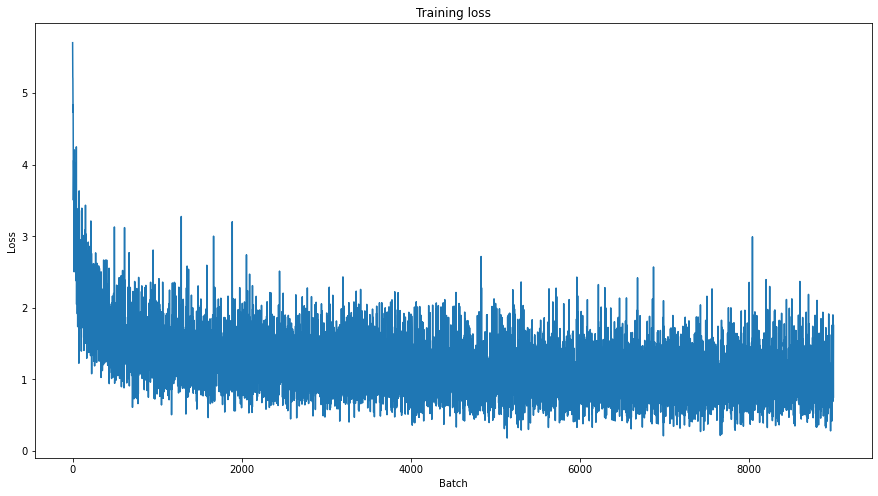

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Load Test Dataset

In [ ]:
input_file = '/content/drive/MyDrive/Final-project/data/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/Final-project/data/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
def  (model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/Final-project/data/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/Final-project/data/Bertprediction/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/Final-project/data/Bertprediction/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/Final-project/data/Bertprediction/null_odds.json"
  output_dir = "/content/drive/MyDrive/Final-project/data/Bertprediction/predict_results"

  write_predictions(val_examples, features, all_results, 100,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = main(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)





Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16






Evaluating:  12%|█▏        | 100/850 [00:14<01:48,  6.91it/s]



Evaluating:  12%|█▏        | 100/850 [00:28<01:48,  6.91it/s]



Evaluating:  24%|██▎       | 200/850 [00:28<01:33,  6.92it/s]



Evaluating:  28%|██▊       | 235/850 [00:33<01:28,  6.93it/s]



Evaluating:  32%|███▏      | 270/850 [00:39<01:23,  6.92it/s]



Evaluating:  36%|███▌      | 305/850 [00:44<01:18,  6.92it/s]



Evaluating:  40%|████      | 340/850 [00:49<01:13,  6.93it/s]



Evaluating:  44%|████▍     | 375/850 [00:54<01:08,  6.93it/s]



Evaluating:  48%|████▊     | 410/850 [00:59<01:03,  6.92it/s]



Evaluating:  52%|█████▏    | 445/850 [01:04<00:58,  6.93it/s]



Evaluating:  56%|█████▋    | 480/850 [01:09<00:53,  6.92it/s]



Evaluating:  61%|██████    | 515/850 [01:14<00:48,  6.93it/s]



Evaluating:  65%|██████▍   | 550/850 [01:19<00:43,  6.93it/s]



Evaluating:  69%|██████▉   | 585/850 [01:24<00:38,  6.93it/s]



Evaluating:  73%|███████▎  | 620/850 [01:29<00:33,  6.93it/s]



Evaluating:  77%|████

{
  "exact": 66.72281647435358,
  "f1": 70.51353411307717,
  "total": 11873,
  "HasAns_exact": 71.7948717948718,
  "HasAns_f1": 79.38717788875893,
  "HasAns_total": 5928,
  "NoAns_exact": 61.665264928511355,
  "NoAns_f1": 61.665264928511355,
  "NoAns_total": 5945,
  "best_exact": 70.5803082624442,
  "best_exact_thresh": -4.600459337234497,
  "best_f1": 73.24828544351521,
  "best_f1_thresh": -3.4874069690704346
}


In [ ]:
# device = torch.device("cuda")
# path = '/content/drive/MyDrive/Final-project/temp/checkpoint-9000/pytorch_model.bin'
# model1 = torch.load(path)
# model1.to(device)

In [ ]:
device = torch.device("cuda")
ckpt_name = '/content/drive/MyDrive/Final-project/temp/checkpoint-9000'
print("Loading model from checkpoint %s" % ckpt_name)
model_trained = BertForQuestionAnswering.from_pretrained(ckpt_name)
model_trained.to(device)

Loading model from checkpoint /content/drive/MyDrive/Final-project/temp/checkpoint-9000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
results2 = evaluate(model_trained, tokenizer)





Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16






Evaluating:  12%|█▏        | 100/850 [00:14<01:48,  6.92it/s]



Evaluating:  12%|█▏        | 100/850 [00:26<01:48,  6.92it/s]



Evaluating:  22%|██▏       | 186/850 [00:26<01:35,  6.92it/s]



Evaluating:  26%|██▌       | 221/850 [00:31<01:30,  6.92it/s]



Evaluating:  30%|███       | 256/850 [00:36<01:25,  6.92it/s]



Evaluating:  34%|███▍      | 291/850 [00:42<01:20,  6.92it/s]



Evaluating:  38%|███▊      | 326/850 [00:47<01:15,  6.93it/s]



Evaluating:  42%|████▏     | 361/850 [00:52<01:10,  6.92it/s]



Evaluating:  47%|████▋     | 396/850 [00:57<01:05,  6.91it/s]



Evaluating:  51%|█████     | 431/850 [01:02<01:00,  6.92it/s]



Evaluating:  55%|█████▍    | 466/850 [01:07<00:55,  6.92it/s]



Evaluating:  59%|█████▉    | 501/850 [01:12<00:50,  6.93it/s]



Evaluating:  63%|██████▎   | 536/850 [01:17<00:45,  6.92it/s]



Evaluating:  67%|██████▋   | 571/850 [01:22<00:40,  6.92it/s]



Evaluating:  71%|███████▏  | 606/850 [01:27<00:35,  6.92it/s]



Evaluating:  75%|████

{
  "exact": 69.93177798366041,
  "f1": 73.0707059516954,
  "total": 11873,
  "HasAns_exact": 63.782051282051285,
  "HasAns_f1": 70.0689088671521,
  "HasAns_total": 5928,
  "NoAns_exact": 76.06391925988225,
  "NoAns_f1": 76.06391925988225,
  "NoAns_total": 5945,
  "best_exact": 70.2097195317106,
  "best_exact_thresh": -0.4838528633117676,
  "best_f1": 73.23017703457947,
  "best_f1_thresh": -0.17512845993041992
}
